In [2]:
# 📦 Imports
import pandas as pd
import pyodbc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# 🔌 Connexion SQL Server
conn = pyodbc.connect(
    'DRIVER={SQL Server};'
    'SERVER=DESKTOP-H2KFI66\FA;'
    'DATABASE=fffffffff;'
    'Trusted_Connection=yes;'
)

# 📥 Requête SQL
query = """
SELECT 
    p.Product_PK,
    cat.Category AS ProductCategory,
    b.brandname AS Brand,
    u.Unit AS UnitMesure,
    COUNT(fd.Material_FK) AS NbMaterials,
    SUM(fd.Dosage) AS TotalDosage
FROM Fact_Dosage fd
JOIN Dim_Product p ON p.Product_PK = fd.Prod_FK
JOIN Dim_Category cat ON cat.Category_PK = p.Category_FK
JOIN Dim_Brand b ON b.Brand_PK = p.Brand_FK
JOIN Dim_Unit u ON u.Unit_PK = fd.Unit_FK
GROUP BY p.Product_PK, cat.Category, b.brandname, u.Unit
"""

# 📤 Lecture des données
df = pd.read_sql(query, conn)
conn.close()

# Nouvelle Feature
df["MoyenneDosage"] = df["TotalDosage"] / df["NbMaterials"]
# 🧹 Nettoyage
df.dropna(inplace=True)

# 🏷️ Encodage des variables catégorielles
for col in ['ProductCategory', 'Brand', 'UnitMesure' , 'MoyenneDosage']:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

# 🧪 Séparation features / target
X = df[['ProductCategory', 'Brand', 'UnitMesure', 'NbMaterials']]
y = df['TotalDosage']

# 🧼 Normalisation
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ✂️ Split Train/Test
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# 🌲 Modèle Random Forest
model = RandomForestRegressor(n_estimators=200, max_depth=10, random_state=42)
model.fit(X_train, y_train)

# 🔮 Prédictions
y_pred = model.predict(X_test)

# 📊 Évaluation
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"✅ MSE: {mse:.2f}")
print(f"✅ R²: {r2:.4f}")


C:\Users\user\AppData\Local\Temp\ipykernel_760\1247888719.py:35: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


✅ MSE: 11.08
✅ R²: 0.3868


In [7]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import pandas as pd
import pyodbc

# Connexion SQL
conn = pyodbc.connect(
    'DRIVER={SQL Server};SERVER=DESKTOP-H2KFI66\FA;DATABASE=fffffffff;Trusted_Connection=yes;'
)

query = """
SELECT 
    p.Product_PK,
    cat.Category AS ProductCategory,
    b.brandname AS Brand,
    u.Unit AS Unit,
    COUNT(fd.Material_FK) AS NbMaterials,
    SUM(fd.Dosage) AS TotalDosage
FROM Fact_Dosage fd
JOIN Dim_Product p ON p.Product_PK = fd.Prod_FK
JOIN Dim_Category cat ON cat.Category_PK = p.Category_FK
JOIN Dim_Brand b ON b.Brand_PK = p.Brand_FK
JOIN Dim_Unit u ON u.Unit_PK = fd.Unit_FK
GROUP BY p.Product_PK, cat.Category, b.brandname, u.Unit
"""

df = pd.read_sql(query, conn)
conn.close()

# Nouvelle Feature
df["MoyenneDosage"] = df["TotalDosage"] / df["NbMaterials"]

# === Linear Regression avec OneHotEncoding ===
features = ["ProductCategory", "Brand", "Unit", "NbMaterials"]
X = df[features]
y = df["TotalDosage"]

# Préprocessing : OneHotEncode les cat features pour Linear Regression
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), ["ProductCategory", "Brand", "Unit"]),
        ('num', 'passthrough', ["NbMaterials"])
    ]
)

pipeline_lr = Pipeline(steps=[
    ('preproc', preprocessor),
    ('regressor', LinearRegression())
])

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entraînement Linear Regression
pipeline_lr.fit(X_train, y_train)
y_pred_lr = pipeline_lr.predict(X_test)

print("\n📌 Linear Regression améliorée")
print(f"✅ MSE: {mean_squared_error(y_test, y_pred_lr):.2f}")
print(f"✅ R²: {r2_score(y_test, y_pred_lr):.4f}")




📌 Linear Regression améliorée
✅ MSE: 11.20
✅ R²: 0.3798


C:\Users\user\AppData\Local\Temp\ipykernel_760\38934063.py:33: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


✅ MSE: 1.0268
✅ R²: 0.9432


C:\Users\user\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


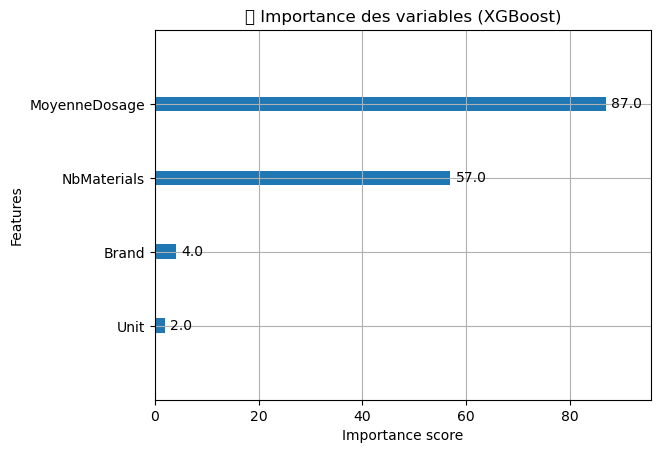

In [6]:
# === XGBoost avec LabelEncoding ===
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

df_encoded = df.copy()
for col in ["ProductCategory", "Brand", "Unit"]:
    df_encoded[col] = LabelEncoder().fit_transform(df_encoded[col])

features_xgb = ["ProductCategory", "Brand", "Unit", "NbMaterials", "MoyenneDosage"]
X_xgb = df_encoded[features_xgb]
y_xgb = df_encoded["TotalDosage"]

# Split the data into training and testing sets
X_train_xgb, X_test_xgb, y_train_xgb, y_test_xgb = train_test_split(
    X_xgb, y_xgb, test_size=0.2, random_state=42
)

xgb_tuned = XGBRegressor(
    n_estimators=50,  # Réduire le nombre d'arbres
    max_depth=2,      # Garder une profondeur faible
    learning_rate=0.05,  # Réduire le taux d'apprentissage
    subsample=0.8,    # Utiliser seulement 80% des données pour chaque arbre
    colsample_bytree=0.8,  # Utiliser seulement 80% des features pour chaque arbre
    random_state=42
)
xgb_tuned.fit(X_train_xgb, y_train_xgb)
y_pred_tuned = xgb_tuned.predict(X_test_xgb)

print(f"✅ MSE: {mean_squared_error(y_test_xgb, y_pred_tuned):.4f}")
print(f"✅ R²: {r2_score(y_test_xgb, y_pred_tuned):.4f}")

from xgboost import plot_importance
import matplotlib.pyplot as plt

plot_importance(xgb_tuned)  # Changed 'xgb' to 'xgb_tuned' to match your model variable
plt.title("📊 Importance des variables (XGBoost)")
plt.show()